In [ ]:
# finds which npm packages are most depended on by others using the top 5000 packages dataset
# combines regular and dev dependencies
# counts how many packages depend on each one
# saves the results in a csv file

In [1]:
import pandas as pd
from ast import literal_eval
from collections import defaultdict

# load the csv
df = pd.read_csv("top_5000_npm_packages.csv")

# turn text into a python list
def safe_parse(x):
    try:
        if pd.isna(x) or x == "[]":
            return []
        return literal_eval(str(x))
    except Exception:
        return []

# parse both dependency columns
df["dependencies_list"] = df["dependencies_list"].apply(safe_parse)
df["devDependencies_list"] = df["devDependencies_list"].apply(safe_parse)

# combine both into one master list
df["all_dependencies"] = df["dependencies_list"] + df["devDependencies_list"]

# build reverse mapping: dependency -> who depends on it
dependents = defaultdict(set)
for _, row in df.iterrows():
    pkg = row["package_name"]
    for dep in row["all_dependencies"]:
        dependents[dep].add(pkg)

# count direct dependents
dependents_count = pd.DataFrame(
    [(pkg, len(dependents[pkg])) for pkg in dependents],
    columns=["package_name", "num_direct_dependents"]
).sort_values("num_direct_dependents", ascending=False)

# keep only the top 500 packages
top_500 = dependents_count.head(500)

# add rank column (1 most depended)
top_500 = top_500.reset_index(drop=True)  # reset old pandas index
top_500.insert(0, "rank", top_500.index + 1)  # add rank starting 1

# save the file
top_500.to_csv("direct_dependents_top500.csv", index=False)
top_500.head(500)

,rank,package_name,num_direct_dependents
0,1,eslint,1236
1,2,typescript,1154
2,3,mocha,1111
3,4,@types/node,740
4,5,prettier,713
...,...,...,...
495,496,deep-equal,16
496,497,vows,16
497,498,parse5,16
498,499,@pika/plugin-build-web,15


count    9393.000000
mean        5.637177
std        31.698617
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max      1236.000000
Name: num_direct_dependents, dtype: float64


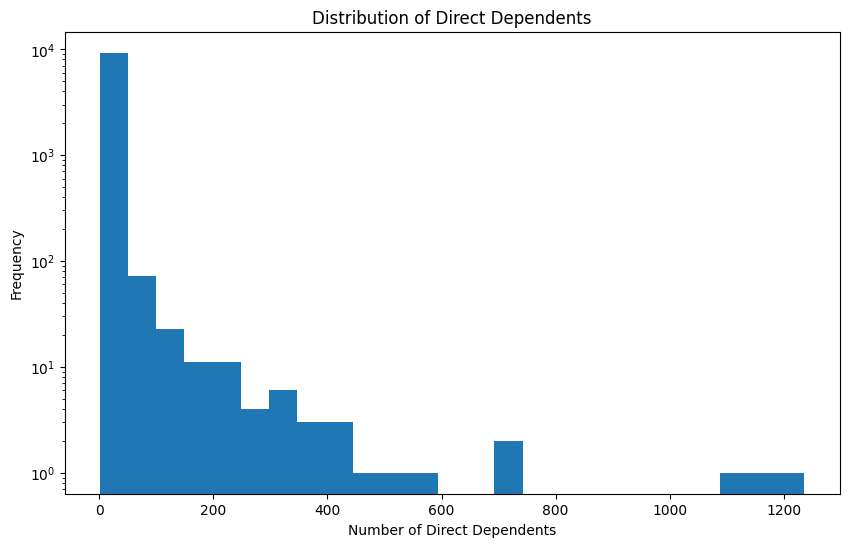

In [11]:
import matplotlib.pyplot as plt

# Get descriptive statistics for the number of direct dependents
print(dependents_count["num_direct_dependents"].describe())

# Plot a histogram to visualize the distribution
dependents_count["num_direct_dependents"].plot(
    kind='hist',
    bins=25,
    title='Distribution of Direct Dependents',
    logy=True,  # Use a log scale for the y-axis due to the long-tail distribution
    figsize=(10, 6)
)
plt.xlabel("Number of Direct Dependents")
plt.show()